# Set observation values, weights and noise

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyemu

Load the "observation data"

In [2]:
obs_csv_fname = os.path.join(
    "..", "models", "synthetic-valley-truth-advanced-monthly", "raw_obs.csv"
)
assert os.path.exists(obs_csv_fname)
obsdf = pd.read_csv(obs_csv_fname, index_col=0, parse_dates=True)
obsdf

,lake-stage,lake-swgw,riv-swgw,riv-flow,wt01-i2-j17,wt02-i3-j10,wt03-i6-j20,wt04-i12-j22,wt05-i14-j11,wt06-i16-j18,...,diff08-i18-j6,diff09-i19-j11,diff10-i18-j22,diff11-i26-j5,diff12-i27-j11,diff13-i28-j23,diff14-i30-j6,diff15-i33-j14,diff16-i36-j1,diff17-i37-j22
datetime,,,,,,,,,,,,,,,,,,,,,
2006-01-01,14.066031,105185.492192,-1.387376e+06,-1.335633e+06,13.246935,13.050041,13.401362,12.544121,12.077999,11.876444,...,0.013717,0.014024,0.002213,0.010162,0.011049,0.003508,0.015260,0.016798,0.017181,0.003387
2006-02-01,14.114155,115051.702802,-1.070749e+06,-1.020837e+06,13.011214,12.940183,13.246186,12.385909,11.914603,11.709383,...,0.010805,0.012262,0.002147,0.007423,0.007658,0.003349,0.012972,0.012585,0.014648,0.003375
2006-03-01,14.162855,119904.221451,-1.013368e+06,-9.670802e+05,13.016951,12.935989,13.268782,12.359310,11.924284,11.685651,...,0.011595,0.013257,0.002373,0.008008,0.008483,0.003798,0.012520,0.013117,0.014263,0.003756
2006-04-01,13.863792,129542.166807,-7.883164e+05,-7.452588e+05,11.999845,12.225009,12.162460,11.618360,11.026492,10.920424,...,0.006436,0.007094,0.001282,0.005043,0.004991,0.001720,0.008859,0.007960,0.009828,0.002092
2006-05-01,13.971163,116413.503236,-9.807520e+05,-9.412915e+05,13.058180,12.917815,13.317623,12.268747,11.959753,11.606303,...,0.014054,0.016556,0.003633,0.008307,0.009671,0.005977,0.010898,0.014965,0.012218,0.005349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-01,13.243941,100277.568088,-6.586417e+05,-6.261954e+05,12.150709,12.279334,12.373858,11.747939,11.084503,11.000883,...,0.006686,0.007592,0.001746,0.004276,0.004414,0.002698,0.006509,0.012416,0.008818,0.003240
2025-10-01,13.075967,99516.101427,-4.584723e+05,-4.375758e+05,12.041146,12.314676,12.319276,11.275845,10.888665,10.483042,...,0.005208,0.006209,0.001913,0.002623,0.002850,0.002151,0.003162,0.010160,0.005115,0.002800
2025-11-01,13.072607,94220.683011,-4.683937e+05,-4.478192e+05,12.520958,12.597128,12.897214,11.411382,11.266410,10.585774,...,0.007388,0.008745,0.002963,0.004517,0.004970,0.003587,0.006217,0.008423,0.006069,0.002943


Since we know the "true" values for our forecast, we will load them up and put the truth values in the control file to make plotting easier (and more interesting)

In [3]:
fore_csv_fname = os.path.join(
    "..", "models", "synthetic-valley-truth-advanced-monthly", "swgw-longterm-means.csv"
)
assert os.path.exists(fore_csv_fname)
foredf = pd.read_csv(fore_csv_fname, index_col=0)
foredf

,hist-mean,pred-mean,diff-mean
quantity,,,
riv-swgw,-1.066177e+06,-7.870405e+05,-2.791365e+05
lake-stage,1.359709e+01,1.340078e+01,1.963096e-01
wel-sum,3.583237e+07,8.056763e+07,-4.473527e+07


In [4]:
working_d = "model_and_pest_files"
assert os.path.exists(working_d)

Models are always going to be low-pass filters compared to the complex natural systems that generated the observations.  So its usually a good idea to filter out high freq signal components:

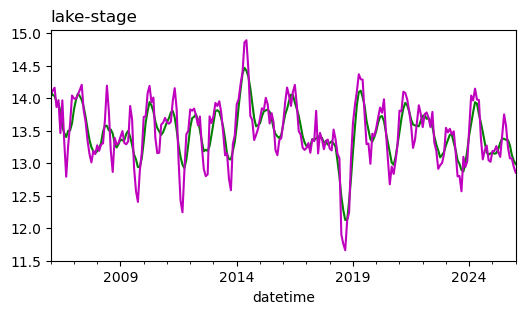

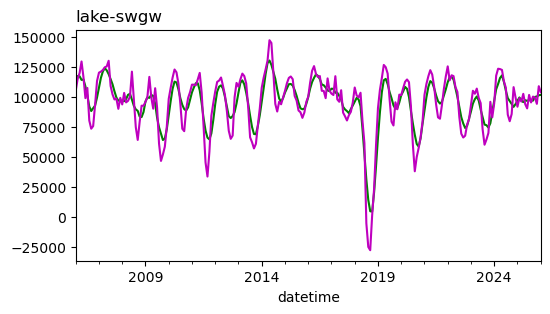

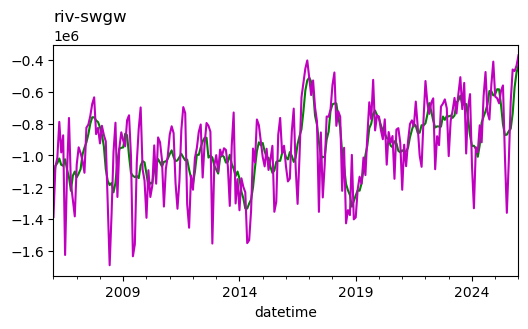

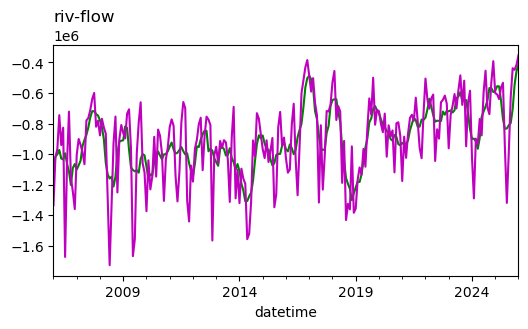

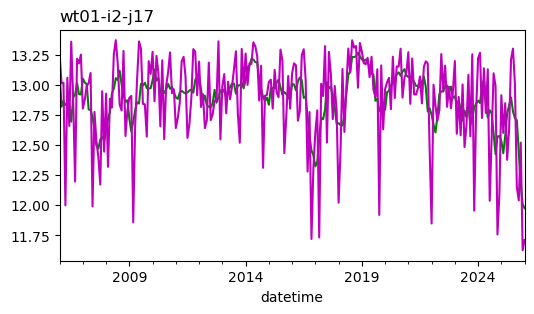

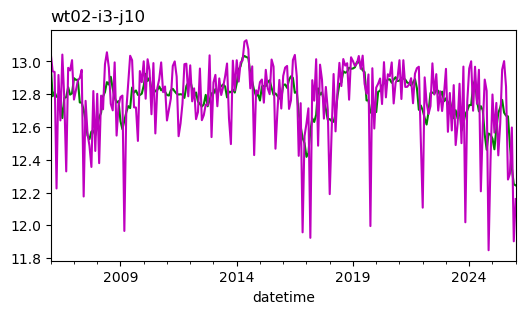

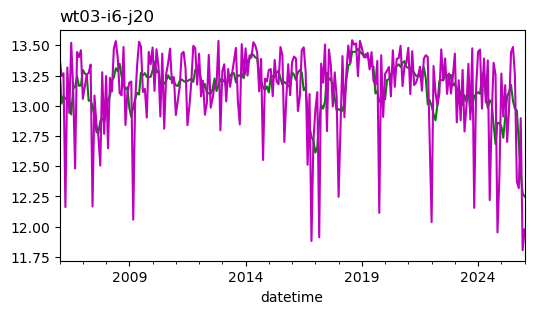

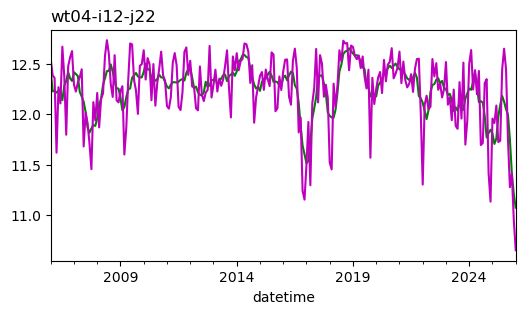

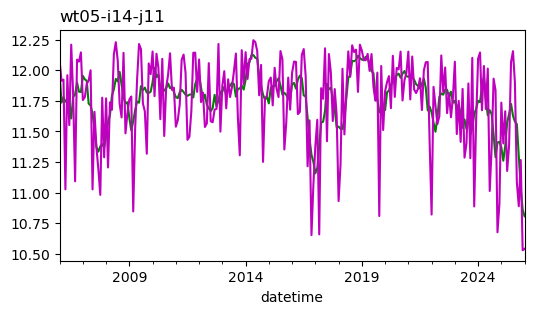

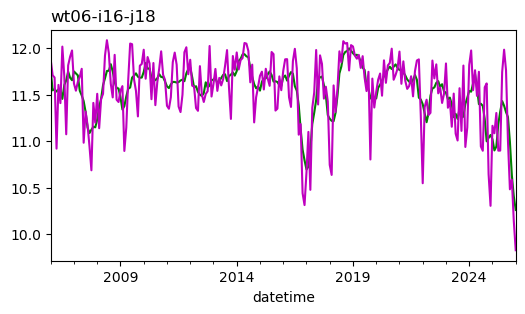

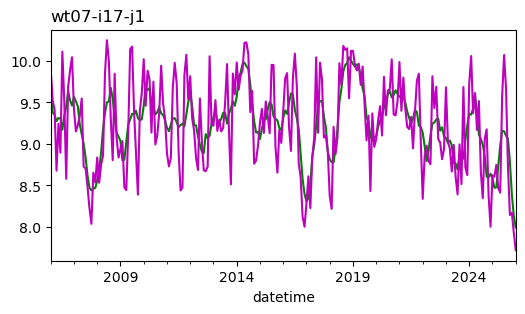

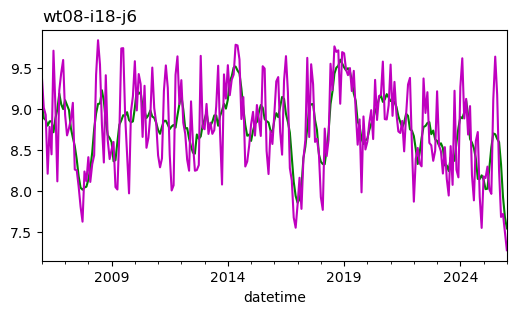

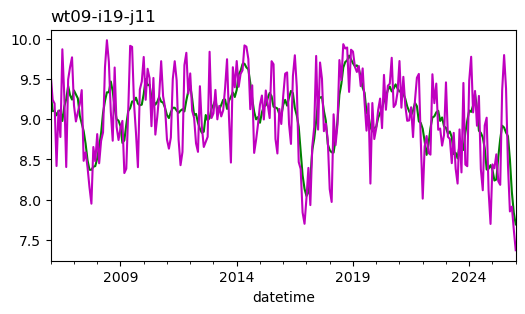

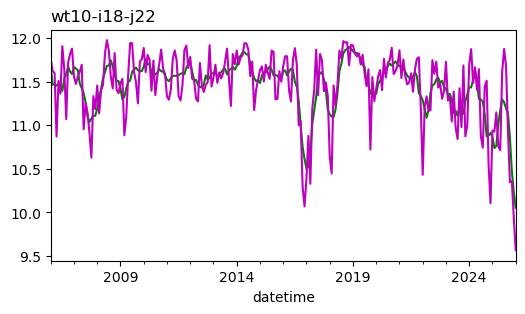

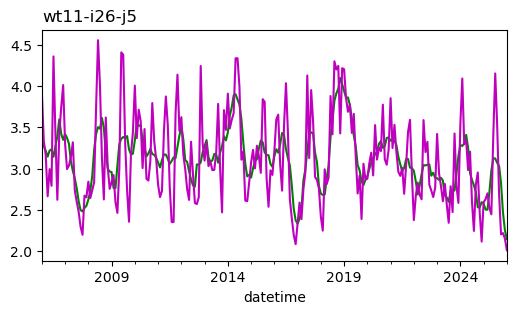

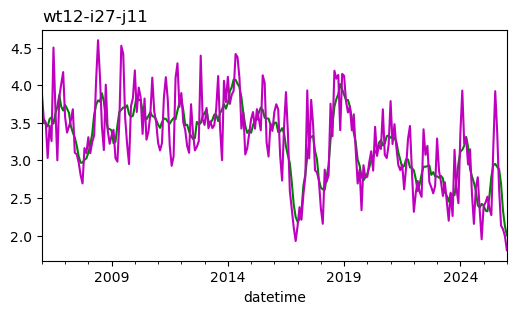

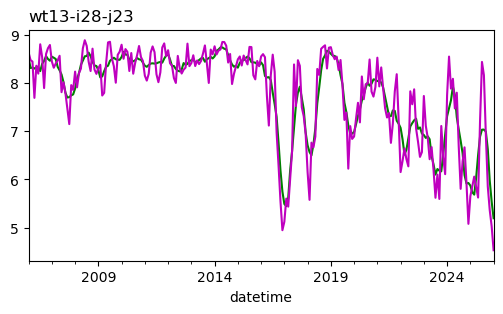

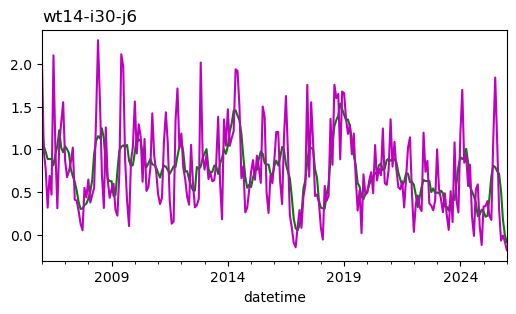

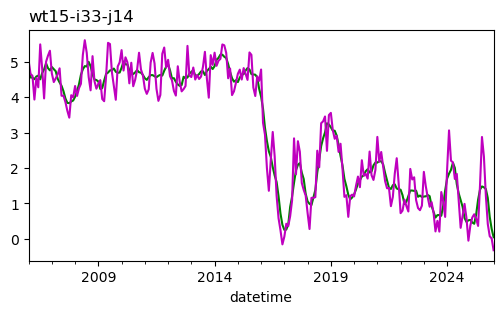

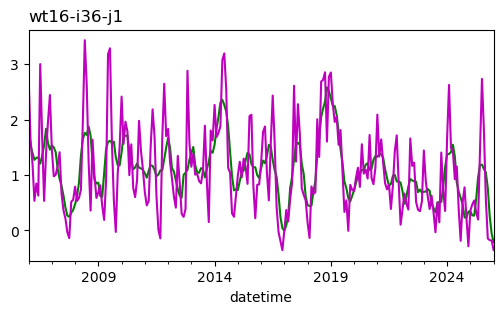

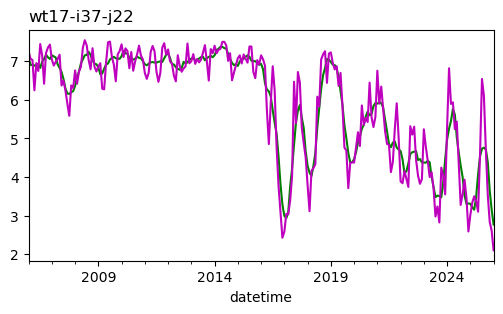

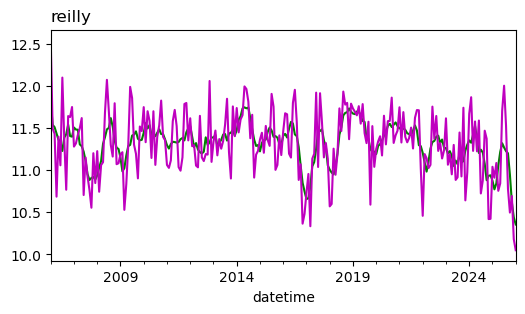

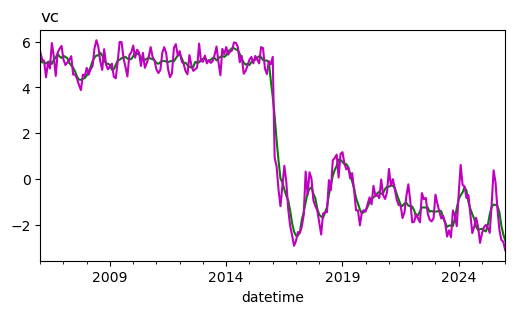

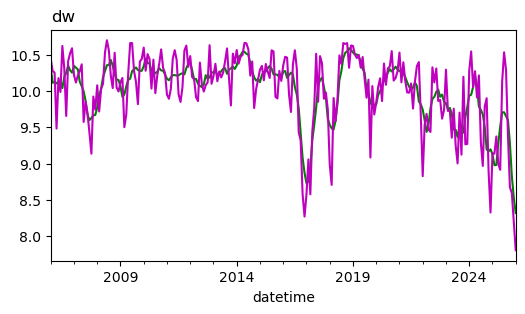

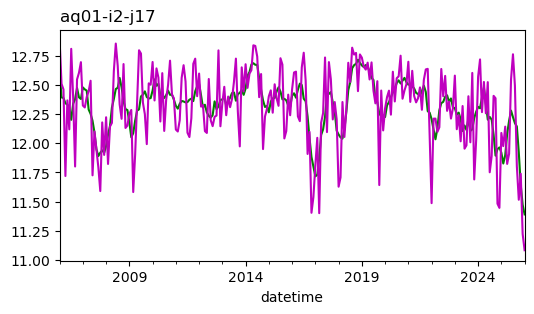

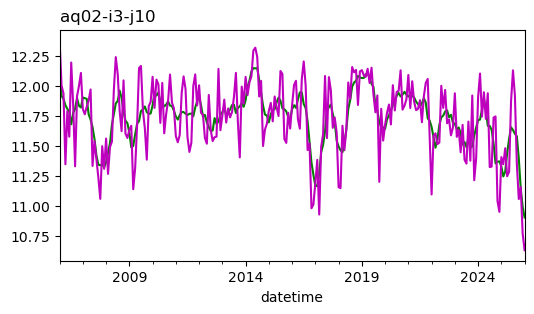

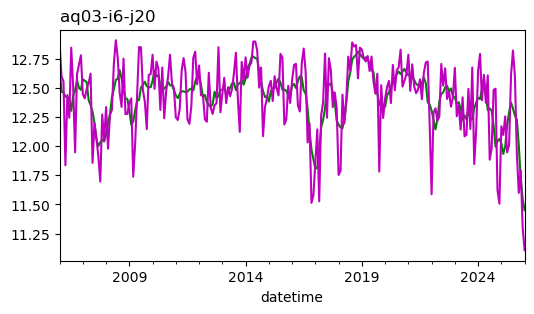

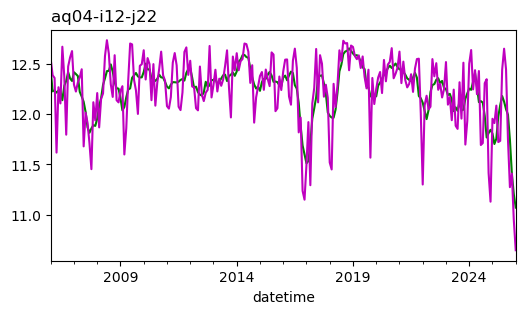

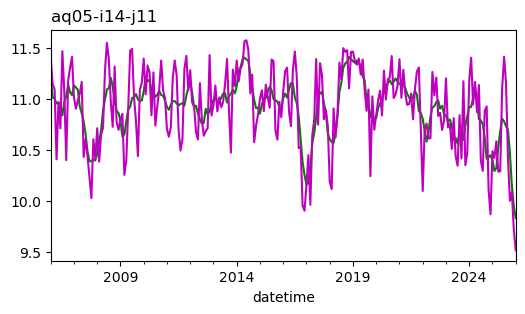

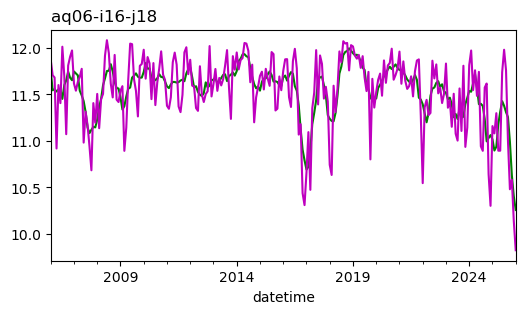

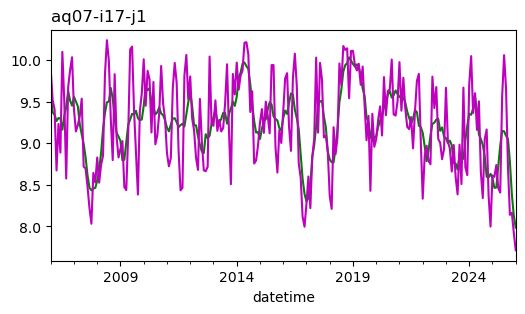

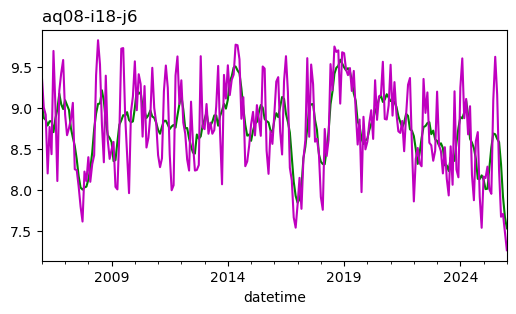

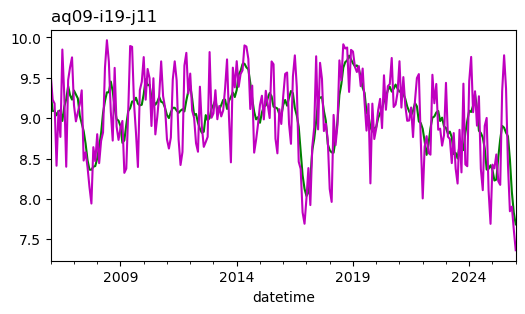

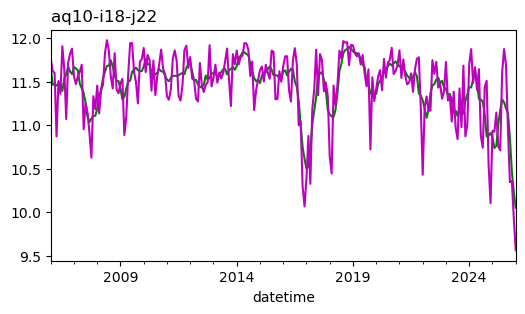

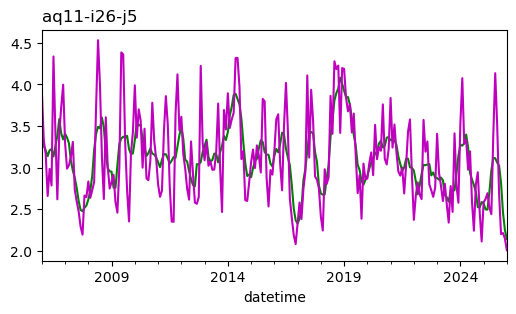

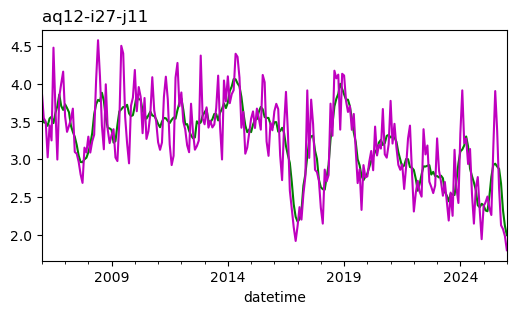

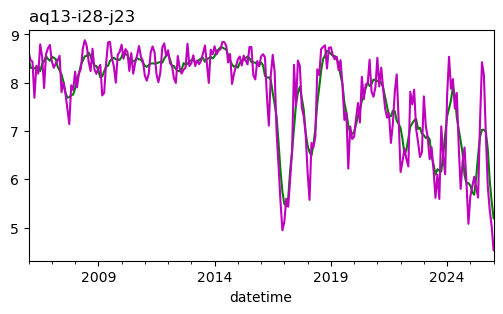

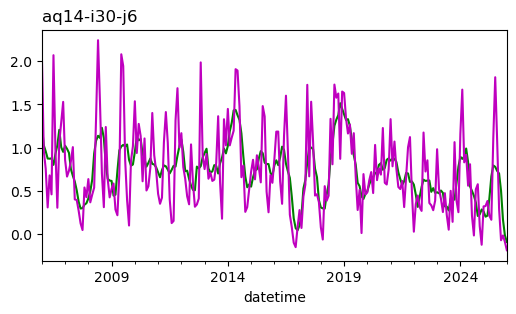

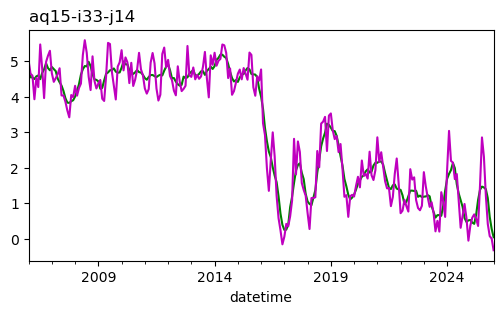

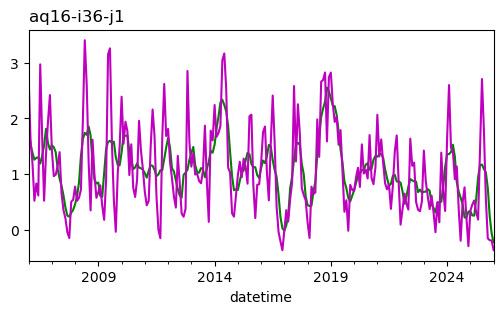

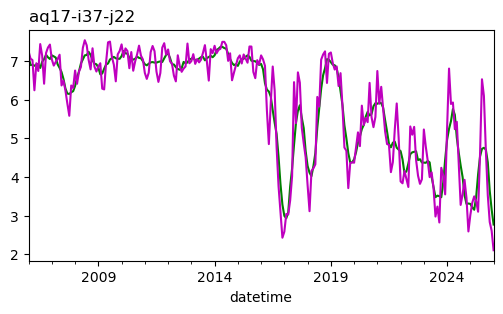

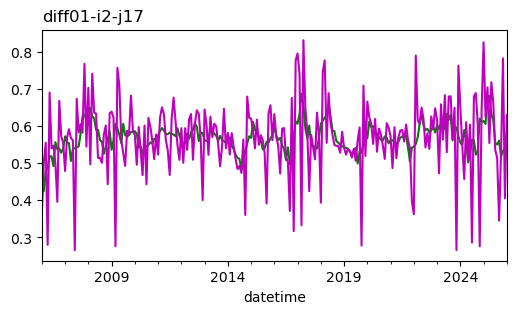

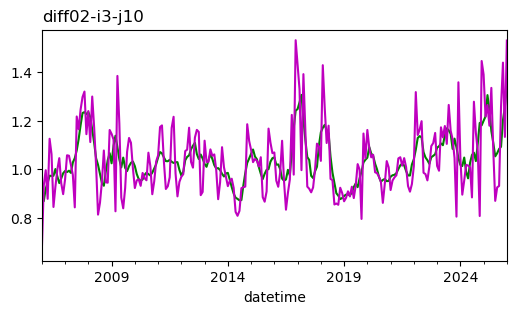

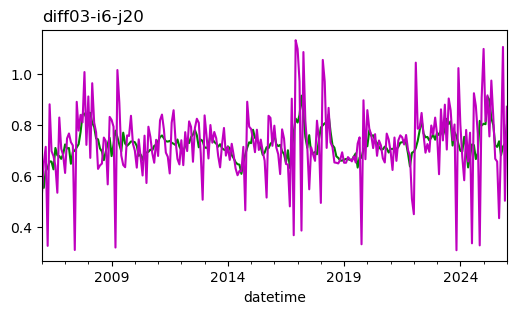

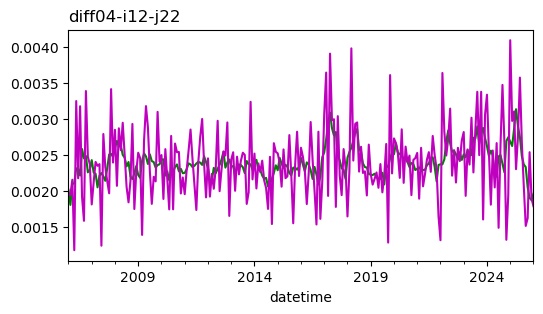

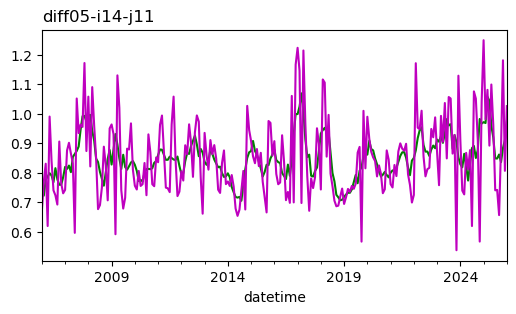

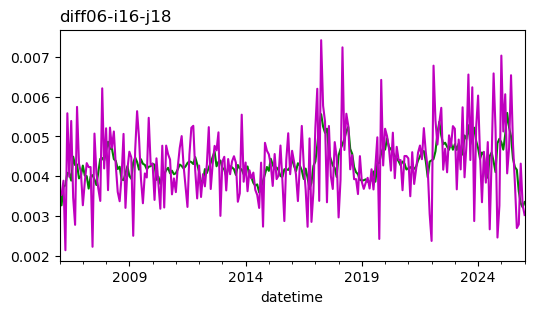

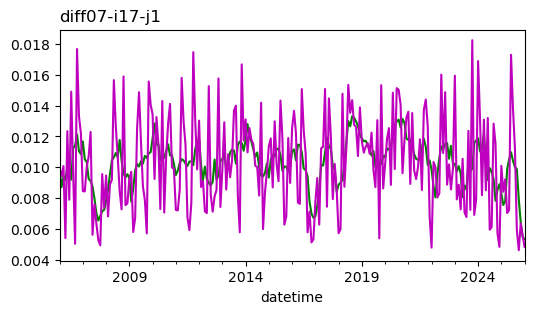

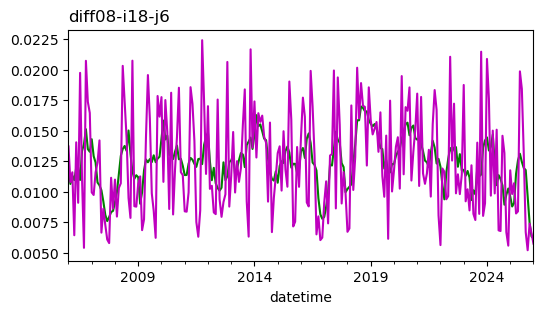

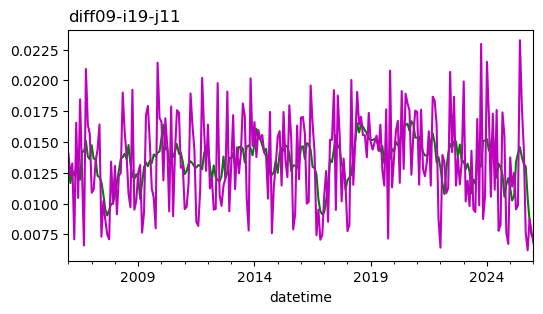

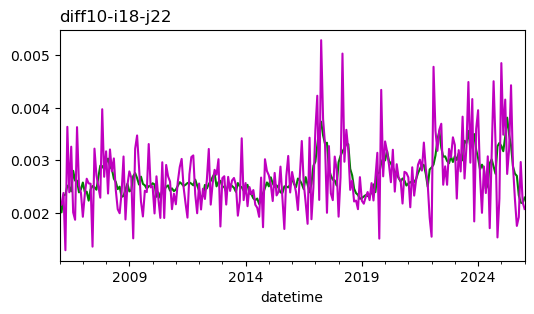

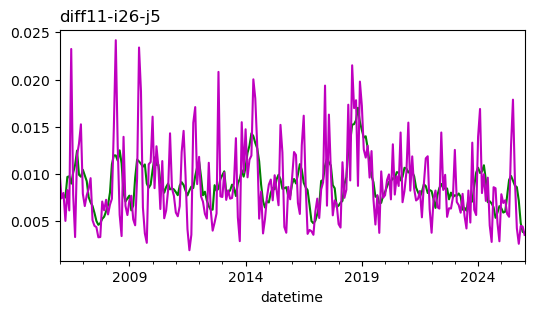

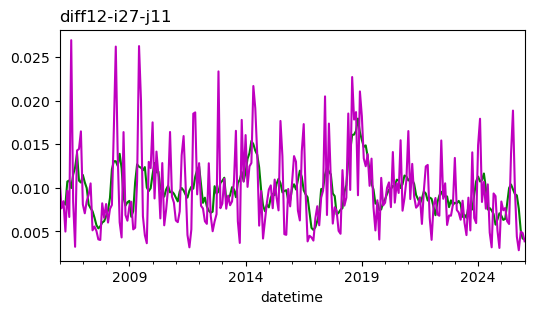

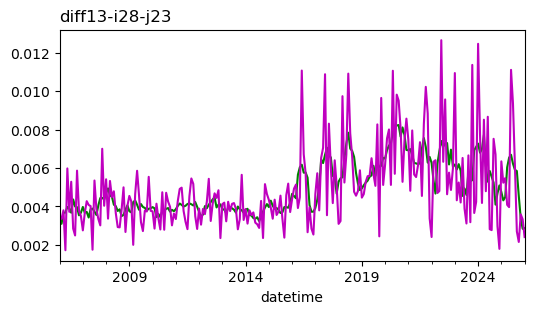

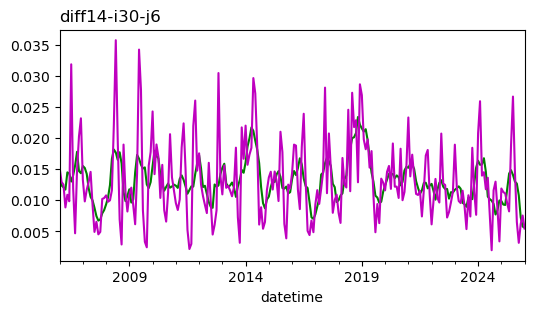

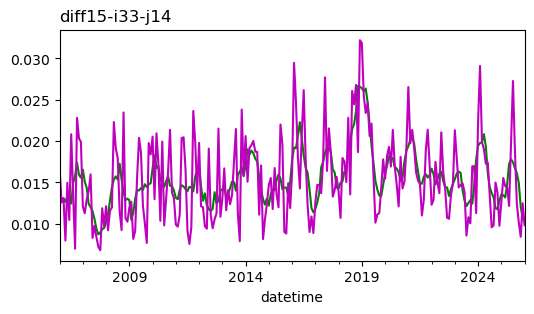

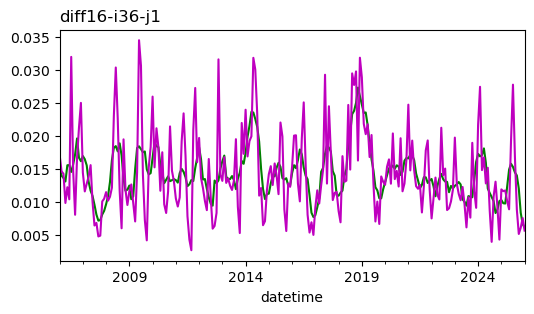

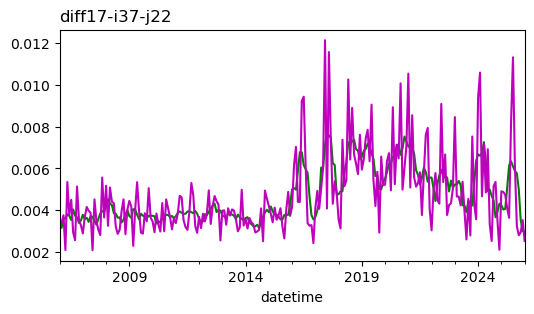

In [5]:
window = 18 #months
smoothed = obsdf.rolling(window=window, center=True, min_periods=1).mean()
for col in smoothed.columns:
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    smoothed.loc[:, col].plot(ax=ax, c="g")
    obsdf.loc[:, col].plot(ax=ax, c="m")
    ax.set_title(col, loc="left")

plt.show()

Now load the control file:

In [6]:
pst = pyemu.Pst(os.path.join(working_d, "pest.pst"))

In [7]:
obs = pst.observation_data

In [8]:
obs.columns

Index(['obsnme', 'obsval', 'weight', 'obgnme', 'datetime', 'i', 'j', 'oname',
       'otype', 'quantity', 'usecol'],
      dtype='object')

First set the truth values for the forecasts (just for plotting later)

In [9]:
for col in foredf.columns:
    fobs = obs.loc[obs.obsnme.str.contains(col), :]
    for name, q in zip(fobs.obsnme, fobs.quantity):
        obs.loc[name, "obsval"] = foredf.loc[q, col]
        print(col, q)

hist-mean lake-stage
hist-mean riv-swgw
hist-mean wel-sum
pred-mean lake-stage
pred-mean riv-swgw
pred-mean wel-sum
diff-mean lake-stage
diff-mean riv-swgw
diff-mean wel-sum


Now for the tricky part: we need to find each simulated output that we have an observed counterpart for.  In practice, this usually requires some bespoke code/hackery (we are also going to set "observed" values from the forecast period, just so we can plot it later)

In [10]:
nnobs = obs.loc[pd.notna(obs.usecol), :]

In [11]:
prefixes = [
    "wt",
    "aq",
    "lake-stage",
    "lake-swgw",
    "riv-flow",
    "riv-swgw",
    "diff1",
    "diff0",
]
for prefix in prefixes:
    uobs = nnobs.loc[nnobs.usecol.str.contains(prefix), :].copy()
    print(prefix, uobs.shape)
    uobs["datetime"] = pd.to_datetime(uobs.datetime)
    for usecol in uobs.usecol.unique():
        print(usecol)
        uuobs = uobs.loc[uobs.usecol == usecol, :].copy()
        for dt, name in zip(uuobs.datetime, uuobs.obsnme):
            oval = smoothed.loc[dt, usecol]
            obs.loc[name, "obsval"] = oval

wt (4097, 11)
wt01-i2-j17
wt02-i3-j10
wt03-i6-j20
wt04-i12-j22
wt05-i14-j11
wt06-i16-j18
wt07-i17-j1
wt08-i18-j6
wt09-i19-j11
wt10-i18-j22
wt11-i26-j5
wt12-i27-j11
wt13-i28-j23
wt14-i30-j6
wt15-i33-j14
wt16-i36-j1
wt17-i37-j22
aq (4097, 11)
aq01-i2-j17
aq02-i3-j10
aq03-i6-j20
aq04-i12-j22
aq05-i14-j11
aq06-i16-j18
aq07-i17-j1
aq08-i18-j6
aq09-i19-j11
aq10-i18-j22
aq11-i26-j5
aq12-i27-j11
aq13-i28-j23
aq14-i30-j6
aq15-i33-j14
aq16-i36-j1
aq17-i37-j22
lake-stage (241, 11)
lake-stage
lake-swgw (0, 11)
riv-flow (0, 11)
riv-swgw (241, 11)
riv-swgw
diff1 (1928, 11)
diff10-i18-j22
diff11-i26-j5
diff12-i27-j11
diff13-i28-j23
diff14-i30-j6
diff15-i33-j14
diff16-i36-j1
diff17-i37-j22
diff0 (2169, 11)
diff01-i2-j17
diff02-i3-j10
diff03-i6-j20
diff04-i12-j22
diff05-i14-j11
diff06-i16-j18
diff07-i17-j1
diff08-i18-j6
diff09-i19-j11


now we need to set the weights and expected noise for each observation datum:

In [12]:
obs["weight"] = 0.0
obs["standard_deviation"] = np.nan
obs["lower_bound"] = np.nan
obs["upper_bound"] = np.nan

In [13]:
obs_dict = {}
hist_prefixes = ["wt", "aq", "lake-stage", "diff1", "diff0"]
for prefix in hist_prefixes:
    uobs = nnobs.loc[nnobs.usecol.str.startswith(prefix), :].copy()
    print(uobs.usecol.unique())
    uobs["datetime"] = pd.to_datetime(uobs.datetime)
    hist_uobs = uobs.loc[uobs.datetime.dt.year < 2015, :]
    obs.loc[hist_uobs.obsnme, "datetime"] = hist_uobs.datetime
    if "lake" in prefix:
        obs.loc[hist_uobs.obsnme, "weight"] = 3.0
        obs.loc[hist_uobs.obsnme, "standard_deviation"] = 0.3
    elif "diff" in prefix:
        print(prefix)
        obs.loc[hist_uobs.obsnme, "weight"] = [
            5.0 if oval > 0.1 else 1.0 for oval in hist_uobs.obsval
        ]
        obs.loc[hist_uobs.obsnme, "standard_deviation"] = [
            max(0.01, oval * 0.1) for oval in hist_uobs.obsval
        ]
        obs.loc[hist_uobs.obsnme, "lower_bound"] = 0.0
    else:
        obs.loc[hist_uobs.obsnme, "weight"] = 2.0
        obs.loc[hist_uobs.obsnme, "standard_deviation"] = 0.5

['wt01-i2-j17' 'wt02-i3-j10' 'wt03-i6-j20' 'wt04-i12-j22' 'wt05-i14-j11'
 'wt06-i16-j18' 'wt07-i17-j1' 'wt08-i18-j6' 'wt09-i19-j11' 'wt10-i18-j22'
 'wt11-i26-j5' 'wt12-i27-j11' 'wt13-i28-j23' 'wt14-i30-j6' 'wt15-i33-j14'
 'wt16-i36-j1' 'wt17-i37-j22']
['aq01-i2-j17' 'aq02-i3-j10' 'aq03-i6-j20' 'aq04-i12-j22' 'aq05-i14-j11'
 'aq06-i16-j18' 'aq07-i17-j1' 'aq08-i18-j6' 'aq09-i19-j11' 'aq10-i18-j22'
 'aq11-i26-j5' 'aq12-i27-j11' 'aq13-i28-j23' 'aq14-i30-j6' 'aq15-i33-j14'
 'aq16-i36-j1' 'aq17-i37-j22']
['lake-stage']
['diff10-i18-j22' 'diff11-i26-j5' 'diff12-i27-j11' 'diff13-i28-j23'
 'diff14-i30-j6' 'diff15-i33-j14' 'diff16-i36-j1' 'diff17-i37-j22']
diff1
['diff01-i2-j17' 'diff02-i3-j10' 'diff03-i6-j20' 'diff04-i12-j22'
 'diff05-i14-j11' 'diff06-i16-j18' 'diff07-i17-j1' 'diff08-i18-j6'
 'diff09-i19-j11']
diff0


if this is an advanced model, we can also use riv-flow information for history matching (one benefit of a more complex model) 

In [14]:
if "riv-flow" in obs.usecol.unique():
    uobs = nnobs.loc[nnobs.usecol == "riv-flow", :].copy()
    uobs["datetime"] = pd.to_datetime(uobs.datetime)
    hist_uobs = uobs.loc[uobs.datetime.dt.year < 2015, :].copy()
    hist_uobs["standard_deviation"] = [
        max(0.2, oval * 0.1) for oval in np.abs(hist_uobs.obsval.values)
    ]
    hist_uobs.loc[hist_uobs.obsnme, "weight"] = 1 / hist_uobs.standard_deviation.values
    obs.loc[hist_uobs.obsnme, "standard_deviation"] = (
        hist_uobs.standard_deviation.values
    )
    obs.loc[hist_uobs.obsnme, "weight"] = hist_uobs.weight.values
    obs.loc[hist_uobs.obsnme, "datetime"] = hist_uobs.datetime

    print(hist_uobs.loc[:, ["obsval", "standard_deviation", "weight"]])

In [15]:
pst.nnz_obs_groups

['oname:sv-gwf-aq-csv_otype:lst_usecol:aq01-i2-j17',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq02-i3-j10',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq03-i6-j20',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq04-i12-j22',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq05-i14-j11',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq06-i16-j18',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq07-i17-j1',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq08-i18-j6',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq09-i19-j11',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq10-i18-j22',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq11-i26-j5',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq12-i27-j11',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq13-i28-j23',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq14-i30-j6',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq15-i33-j14',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq16-i36-j1',
 'oname:sv-gwf-aq-csv_otype:lst_usecol:aq17-i37-j22',
 'oname:sv-gwf-wt-csv_otype:lst_usecol:wt01-i2-j17',
 'oname:sv-gwf-wt-csv_otype:lst_useco

Set noptmax to 0, save the control file and do a test run:

In [16]:
pst.control_data.noptmax = 0
pst.write(os.path.join(working_d, "pest.pst"), version=2)
pyemu.os_utils.run("pestpp-ies pest.pst", cwd=working_d)

noptmax:0, npar_adj:1066, nnz_obs:5616
pestpp-ies pest.pst


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team

...processing command line: ' pestpp-ies pest.pst'
...using serial run manager


version: 5.2.25
binary compiled on Jan  6 2026 at 12:27:13
using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/modflow-pest-tampa-2026/exercises/notebooks/model_and_pest_files"
on host: "macminiller.local"
on a(n) apple operating system
with release configuration
started at 01/14/26 08:57:51

processing control file pest.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

noptmax = 0, resetting max_run_fail = 1
parameter warning: 1 parameters are at upper bound
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  

  ---  'noptmax'=0, running control file parameter values and quitting  ---  
...saving control file parameter ensemble to  pest.base.p

Now we are going to generate some autocorrelated timeseries noise to use in the history matching:

In [17]:
nzobs = obs.loc[obs.weight > 0, :].copy()
obs["distance"] = np.nan
grps = nzobs.obgnme.unique()
grps.sort()
struct_dict = {}
for grp in grps:
    gobs = nzobs.loc[nzobs.obgnme == grp, :].copy()
    gobs["datetime"] = pd.to_datetime(gobs.datetime)
    gobs["distance"] = (gobs.datetime - gobs.datetime.min()).dt.days
    obs.loc[gobs.obsnme, "distance"] = gobs.distance
    v = pyemu.geostats.ExpVario(contribution=1.0, a=365 * 20)
    gs = pyemu.geostats.GeoStruct(variograms=v, name=grp)
    names = gobs.obsnme.to_list()
    names.sort()
    struct_dict[gs] = names

In [18]:
np.random.seed(pyemu.en.SEED)

In [19]:
noise = pyemu.helpers.autocorrelated_draw(
    pst, struct_dict, num_reals=1000, verbose=True, enforce_bounds=True
)

--> getting full diagonal cov matrix
-->draw full obs en from diagonal cov
-->processing cov matrix for 108 items with gs name:oname:sv-gwf-aq-csv_otype:lst_usecol:aq01-i2-j17,nugget:0.0,structures:
name:var1,contribution:1.0,a:7300.0,anisotropy:1.0,bearing:0.0

...scaling rows and cols
...draw
-->processing cov matrix for 108 items with gs name:oname:sv-gwf-aq-csv_otype:lst_usecol:aq02-i3-j10,nugget:0.0,structures:
name:var1,contribution:1.0,a:7300.0,anisotropy:1.0,bearing:0.0

...scaling rows and cols
...draw
-->processing cov matrix for 108 items with gs name:oname:sv-gwf-aq-csv_otype:lst_usecol:aq03-i6-j20,nugget:0.0,structures:
name:var1,contribution:1.0,a:7300.0,anisotropy:1.0,bearing:0.0

...scaling rows and cols
...draw
-->processing cov matrix for 108 items with gs name:oname:sv-gwf-aq-csv_otype:lst_usecol:aq04-i12-j22,nugget:0.0,structures:
name:var1,contribution:1.0,a:7300.0,anisotropy:1.0,bearing:0.0

...scaling rows and cols
...draw
-->processing cov matrix for 108 items w

Save the noise ensemble, tell ies about it, and an noptmax=-2 test run:

In [20]:
noise.to_csv(os.path.join(working_d, "noise.csv"))
pst.pestpp_options = {"ies_par_en": pst.pestpp_options["ies_par_en"]}
pst.pestpp_options["ies_obs_en"] = "noise.csv"
pst.control_data.noptmax = -2
pst.write(os.path.join(working_d, "pest.pst"), version=2)
pyemu.os_utils.run("pestpp-ies pest.pst", cwd=working_d)

noptmax:-2, npar_adj:1066, nnz_obs:5616
pestpp-ies pest.pst


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team

...processing command line: ' pestpp-ies pest.pst'
...using serial run manager


version: 5.2.25
binary compiled on Jan  6 2026 at 12:27:13
using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/modflow-pest-tampa-2026/exercises/notebooks/model_and_pest_files"
on host: "macminiller.local"
on a(n) apple operating system
with release configuration
started at 01/14/26 08:58:16

processing control file pest.pst
parameter warning: 1 parameters are at upper bound
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  
...using glm algorithm
...using REDSVD for truncated svd solve
...maxsing: 10000000
...eigthresh:  1e-06
...initializing localizer
...not using localization
...using lambda multipliers: 0.1 , 1 , 10 , 
...using lambda scaling factors: 0.75 , 1 , 1.1 

As you can see from the phi group summary, we need some rebalanced weights.  One way to do this is the the ies_phi_factor_file:

In [21]:
phi_factors = {"lake": 0.2, "aq": 0.3, "wt": 0.3, "diff": 0.2}
if "riv-flow" in obs.usecol.unique():
    phi_factors = {"lake": 0.15, "aq": 0.25, "wt": 0.25, "diff": 0.15, "riv-flow": 0.2}
# phi_factors["diff"] = 1e-20
ser = pd.Series(phi_factors)
ser.to_csv(os.path.join(working_d, "phi_facs.csv"), index=True, header=False)
pst.pestpp_options["ies_phi_factor_file"] = "phi_facs.csv"
pst.write(os.path.join(working_d, "pest.pst"), version=2)
pyemu.os_utils.run("pestpp-ies pest.pst", cwd=working_d)

noptmax:-2, npar_adj:1066, nnz_obs:5616
pestpp-ies pest.pst


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team

...processing command line: ' pestpp-ies pest.pst'
...using serial run manager


version: 5.2.25
binary compiled on Jan  6 2026 at 12:27:13
using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/modflow-pest-tampa-2026/exercises/notebooks/model_and_pest_files"
on host: "macminiller.local"
on a(n) apple operating system
with release configuration
started at 01/14/26 08:58:43

processing control file pest.pst
parameter warning: 1 parameters are at upper bound
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  
...checking phi factors in file phi_facs.csv
...using glm algorithm
...using REDSVD for truncated svd solve
...maxsing: 10000000
...eigthresh:  1e-06
...initializing localizer
...not using localization
...using lambda multipliers: 0.1 , 1 , 10 , 
...